In [1]:
#Importar bibliotecas 
import pandas as pd
import ID3_tree_implementation as id3

In [2]:
#Leituras das tabelas apos tratamento de dados
users = pd.read_csv("cleaned_users.csv",sep = ";",index_col = 0)
df = pd.read_csv("cleaned_ratings.csv",sep = ";")
movies = pd.read_csv("cleaned_movies.csv",sep = ";", index_col = 0)

In [3]:
#Desnormalização das tabelas, considerando que a primeira coluna é o atributo que se deseja prever
df = df.join(movies, on = "MovieID", how = "left")
df.drop("MovieID", axis = 1, inplace = True)
df = df.join(users,on = "UserID", how = "left")
df.drop("UserID", axis = 1, inplace = True)

In [4]:
#Análise de dados faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Rating      1000209 non-null  int64 
 1   Title       1000209 non-null  object
 2   Genres      1000209 non-null  int64 
 3   Gender      1000209 non-null  object
 4   Occupation  1000209 non-null  int64 
 5   Zip-code    992313 non-null   object
 6   Age         1000209 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.4+ MB


In [5]:
#Percebe-se que para o zip code existem 7869 valores nulos, isso corresponde a 0.7% da quantidade de dados.
#Mesmo sendo pouca a quantidade de dados, é possivel preencher esse valor da seguinte forma:

#Iterar por todas as linhas que contem um valor NaN
for index,line in df.loc[df.isnull().any(axis = 1)].iterrows():

    #Selecionar o local em que o filme foi mais assistido
    #É importante ressaltar que se utiliza o parametro Zip-code aqui porque ja se sabe que só a coluna Occupation possui valores NaN
    serie_for_analysis = df.loc[df.Title == line.Title,'Zip-code'].value_counts()

    #Para se utilizar a mesma cidade defini-se que é necessário pelo menos 50 respostas vindas dessa mesma cidade para o filme em questao
    #Isso porque para filmes que tem poucas respostas, adicionar a cidade a essa linha que tem dado faltante pode interfirir significativamente no resultado
    if (len(serie_for_analysis) != 0 and serie_for_analysis[0] >= 50):
        df.loc[index,'Zip-code'] = serie_for_analysis.index[0]

In [6]:
#Análise do novo dataframe 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Rating      1000209 non-null  int64 
 1   Title       1000209 non-null  object
 2   Genres      1000209 non-null  int64 
 3   Gender      1000209 non-null  object
 4   Occupation  1000209 non-null  int64 
 5   Zip-code    998295 non-null   object
 6   Age         1000209 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.4+ MB


In [7]:
#Diminuiu a quantidade de campos nulos, mas ainda existem alguns assim. Para corrigir isso excluiremos as linhas que ainda contema algum campo nulo
df.dropna(inplace = True)
df.info()

#Percebe-se que a quantidade agora esta correta

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998295 entries, 0 to 1000208
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Rating      998295 non-null  int64 
 1   Title       998295 non-null  object
 2   Genres      998295 non-null  int64 
 3   Gender      998295 non-null  object
 4   Occupation  998295 non-null  int64 
 5   Zip-code    998295 non-null  object
 6   Age         998295 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 60.9+ MB


In [27]:
#Treinar o modelo
tree = id3.Tree()
tree.train(df)

In [42]:
#Lendo o arquivo que se deseja prever
test_dataset = pd.read_csv('answer.csv', sep = ';')

In [43]:
#Criar o classificador a priori
priori = df[['Rating','Title']].groupby('Title').mean()

In [44]:
#Predizer os valores baseados nas inforamções dadas
#Testar no modelo id3
id3_result = tree.predict(test_dataset)

#Testar o priori
priori_result = []
for _,line in test_dataset.iterrows():
    priori_result.append(priori.loc[line.Title].Rating)

#Armazenar os resultados reais
real_result = test_dataset.loc[:,'Rating']

In [45]:
#Avaliação dos modelos pelo método do chi2
#Definir a função
def chi2(real,predict):
    total = 0
    for num1,num2 in zip(real,predict):
        total += (num1-num2)*(num1-num2)
    
    return total

chi2_id3 = chi2(real_result,id3_result)
chi2_priori = chi2(real_result,priori_result)
print(f'id3: {chi2_id3}    priori: {chi2_priori}')

id3: 6    priori: 6.454459339837603


In [46]:
#Percebe-se que os dois índices são praticamente iguais

In [47]:
#Avaliação dos modelos pela matrix de confusão
#Importar biblioteca para visualizar melhor a matriz
import seaborn as sns

#Definir a função que faz a matriz
def confusion_matrix(predict_values,real_values):
    #Criar uma matriz conforme as categorias
    matrix = pd.DataFrame([[0 for j in range(5)] for i in range(5)], columns = [1,2,3,4,5], index = [1,2,3,4,5])

    #Preencher a matriz
    for predict_value,real_value in zip(predict_values,real_values):
        matrix.loc[real_value,predict_value] += 1
    
    return matrix

#Para esse é necessário que os valores sejam inteiros
priori_result = list(map(lambda x: int(round(x,0)), priori_result))

confusion_matrix_id3 = confusion_matrix(id3_result,real_result)
confusion_matrix_priori = confusion_matrix(priori_result,real_result)

<AxesSubplot:>

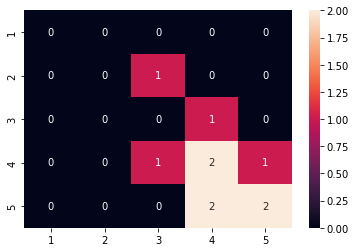

In [48]:
sns.heatmap(confusion_matrix_id3, vmin = 0, annot  = True)

<AxesSubplot:>

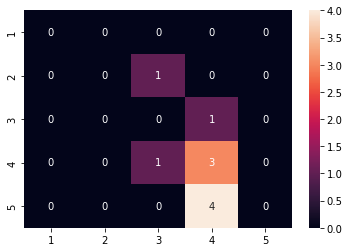

In [49]:
sns.heatmap(confusion_matrix_priori, vmin = 0, annot  = True)

In [50]:
#Avaliação da precisão
#Definir função que calcula
def accuracy(confusion_matrix):
    result = 0

    #Percorrer os elementos da diagonal principal
    for i in range(1,6):
        result += confusion_matrix.loc[i,i]
    
    #Dividir pelo total e retornar
    return result/confusion_matrix.sum().sum()

id3_accuracy = accuracy(confusion_matrix_id3)
priori_accuracy = accuracy(confusion_matrix_priori)
print(f'precisão id3: {id3_accuracy}    precisão priori: {priori_accuracy}')

precisão id3: 0.4    precisão priori: 0.3


In [51]:
#Em relação a matrix de confusão, os dois modelos se aroximam também 
#A precisão dos dois é bem próxima
#Além disso, os valores que foram previstos errados estão localizados próximos a diagonal principal
#Percebe-se que o modelo id3 é mais consistente porque os valores previstos estão mais distribuidos, no modelo a priori, 80% das vezes ele disse que o resultado seria 4

In [52]:
#Análise pelo coeficiente kappa
#Definir a função
def kappa(confusion_matrix):
    result = 0
    total = confusion_matrix.sum().sum()

    #Definir o percentual de cada coluna
    percentual = []
    for column in range(1,6):
        percentual.append(confusion_matrix.loc[:,column].sum()/total)
    
    #Definir uma nova matrix
    new_matrix = pd.DataFrame([[0 for j in range(5)] for i in range(5)], columns = [1,2,3,4,5], index = [1,2,3,4,5])
    for line in range(1,6):
        line_sum = confusion_matrix.loc[line,:].sum()
        for column in range(1,6):
            new_matrix.loc[line,column] = line_sum*percentual[column-1]
    return (accuracy(confusion_matrix)-accuracy(new_matrix))/(1-accuracy(new_matrix))

kappa_id3 = kappa(confusion_matrix_id3)
kappa_priori = kappa(confusion_matrix_priori)
print(f'kappa id3: {round(kappa_id3,4)}   kappa priori: {round(kappa_priori,4)}')

kappa id3: 0.0909   kappa priori: -0.0606


In [ ]:
#Percebe-se que apesar de terem uma acuracia próxima, o modelo id3 é levemente melhor como demonstra o kappa
#Isso acontece porque o modelo a priori coloca a maioria das previsões como 4, e acaba acertando por coincidencia de como o test_dataset esta distribuido
#Mesmo assim, o modelo id3 não possui resultados muito bons, isso se deve a como foi construido o dataset teste. 
#O dataset de treinamento foi construido por ratings de pessoas brasileiras enquanto todo o dataset de treino é de pessoas os EUA, que possuem culturas diferentes
#Além disso, o dataset de teste é muito pequeno e cada erro ganha uma proporcionalidade muito maior